In [9]:
import src.etl as etl
import src.one_hot_encode_pipeline as ONE

import numpy as np
import pandas as pd
import timeit
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import ast
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
random.seed(4612)

## ETL Process

In [7]:
location = 'data/public_data.csv'
df_original = pd.read_csv(location, encoding = "ISO-8859-1")

In [13]:
df_etl = etl.transform_dataframe(df_original)
df = etl.split_categories(df_etl, df_etl.category)

df_credit = df
df_debit = df[df.amount < 0]

In [14]:
print(len(df_credit))
print(len(df_debit))

8996
1533


In [15]:
y = df.income.values
X = df.drop(['income'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4612)

all_categories, one_hot_df = ONE.one_hot_get_dummies_train(X_train, 
                        column_selection=['category_1','category_2','category_3'],
                        column_names=df.columns.drop('income'))

In [17]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   stop_words='english',
                                   token_pattern=r'\b[^\d\W]{3,}\b', #u'(?![0-9]{4,})(?!\d+-\d+)(?!\d+/\d+)(?:^\S*)',
                                   lowercase=True)

X_train_df = pd.DataFrame(X_train, columns=df.columns.drop('income')).drop(['category_1',
                                                                           'category_2',
                                                                           'category_3'],axis=1)
X_train_names = X_train_df.description
tfidf_fit = tfidf_vectorizer.fit_transform(X_train_names)

In [18]:
tfidf_df = pd.DataFrame(tfidf_fit.toarray(), columns=tfidf_vectorizer.get_feature_names())

X_train_hot_tfidf = pd.concat([X_train_df.drop(['description'], axis=1), one_hot_df, tfidf_df], axis=1).values

In [19]:
len(X_train_hot_tfidf[0])

2554

In [20]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

### Test Set

In [22]:
hot_test_df = ONE.one_hot_get_dummies_test(X_test,
                        all_categories=all_categories,
                        column_selection=['category_1','category_2','category_3'],
                        column_names=df.columns.drop('income'))

In [23]:
X_test_df = pd.DataFrame(X_test, columns=df.columns.drop('income')).drop(['category_1',
                                                                          'category_2',
                                                                          'category_3'],axis=1)
X_test_names = X_test_df['description']
tfidf_transform = tfidf_vectorizer.transform(X_test_names)
tfidf_transform_df = pd.DataFrame(tfidf_transform.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [24]:
X_test_new = pd.concat([X_test_df.drop(['description'], axis=1), hot_test_df, tfidf_transform_df], axis=1).values

In [25]:
len(X_test_new[0])

2554

In [17]:
#test[test.isna().any(axis=1)]

In [26]:
random_forest = RandomForestClassifier(n_estimators=100,
                                      class_weight={0:1,1:1}) #1:10000000
random_forest.fit(X_train_hot_tfidf, y_train)
rf_pred = random_forest.predict(X_test_new)

In [27]:
FP = np.sum((y_test == 1.0) & (rf_pred == 0.0))
FN = np.sum((y_test == 0.0) & (rf_pred == 1.0))
TP = np.sum((y_test == 1.0) & (rf_pred == 1.0))
TN = np.sum((y_test == 0.0) & (rf_pred == 0.0))

print("FP: %s" % FP)
print("FN: %s" % FN)
print("TP: %s" % TP)
print("TN: %s" % TN)
print("Sum: %s" % (FP+FN+TP+TN))

FP: 24
FN: 3
TP: 58
TN: 2884
Sum: 2969


In [28]:
confusion_matrix(y_test, rf_pred)

array([[2884,    3],
       [  24,   58]])

In [30]:
feature_importance = random_forest.feature_importances_
col_names = pd.concat([X_train_df.drop(['description'], axis=1), one_hot_df, tfidf_df], axis=1).columns

In [32]:
top_list = []
features = []
for value in np.argsort(feature_importance)[::-1][0:12]:
    top_list.append(col_names[value])
    top_list.append(feature_importance[value])
top_list

['amount',
 0.19839315068061267,
 'category_2__Payroll',
 0.10674285676232448,
 'deposit',
 0.04948680240570414,
 'payroll',
 0.025475963492013563,
 'rcv',
 0.02122246864445349,
 'amount_tens',
 0.021063910012271855,
 'category_2__Deposit',
 0.02014985209915887,
 'pmnt',
 0.014299370140232592,
 'dir',
 0.012964089731597102,
 'payr',
 0.011323450361074383,
 'Friday',
 0.010993753215955176,
 'external',
 0.010536423138202205]

/Users/sambk/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


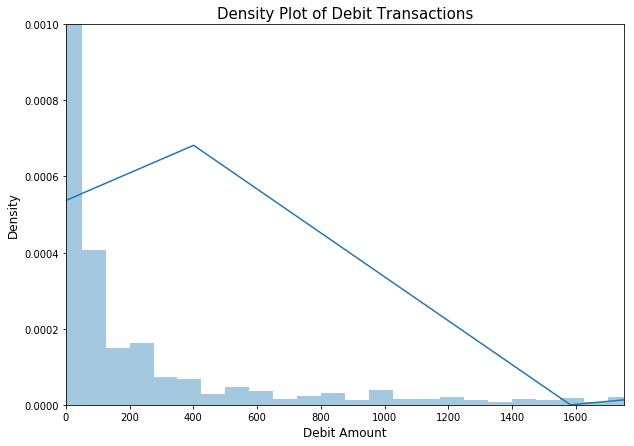

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(-(df.amount), bins=2000)
plt.xlim([0,1750])
plt.ylim([0,0.001])
plt.xlabel("Debit Amount", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Density Plot of Debit Transactions", fontsize=15)
plt.show()